<a href="https://colab.research.google.com/github/Alexflames/risks-code/blob/master/Gravitymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

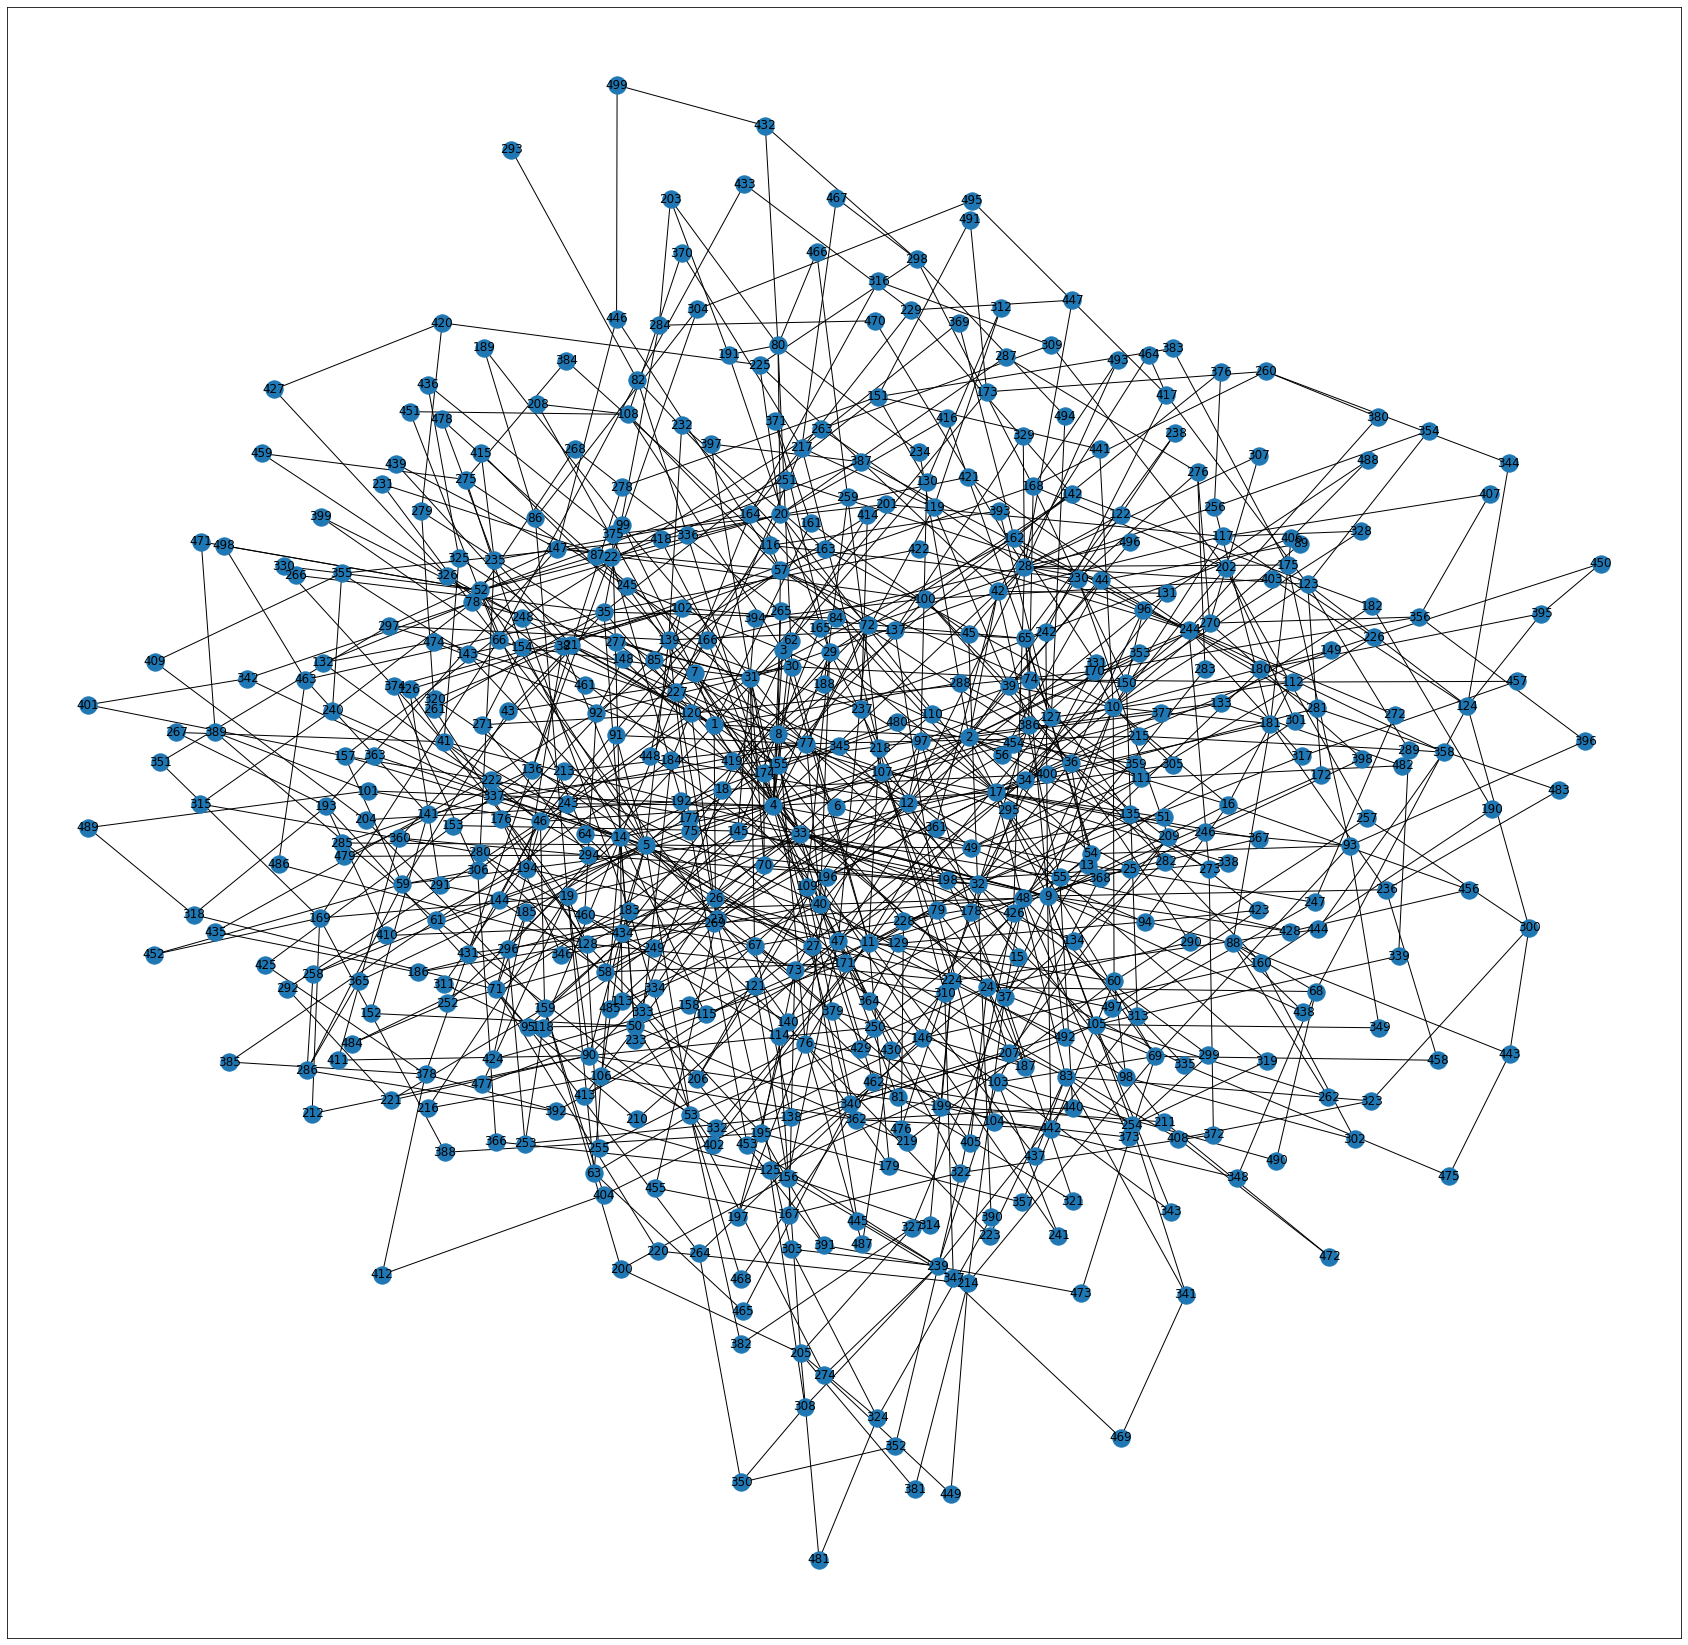

In [18]:
import networkx as nx
import random as rand
import matplotlib.pyplot as plt

def binarySearch(data, val):
    highIndex = len(data)-1
    lowIndex = 0
    while highIndex > lowIndex:
            index = (highIndex + lowIndex) // 2
            sub = data[index]
            if data[lowIndex] == val:
                    return [lowIndex, lowIndex]
            elif sub == val:
                    return [index, index]
            elif data[highIndex] == val:
                    return [highIndex, highIndex]
            elif sub > val:
                    if highIndex == index:
                            return sorted([highIndex, lowIndex])
                    highIndex = index
            else:
                    if lowIndex == index:
                            return sorted([highIndex, lowIndex])
                    lowIndex = index
    return sorted([highIndex, lowIndex])

class Gravitymodel:

  def compute_probability_range(self, array, sum_array, tuple_length = 1, tuple_i = 1):
    value_p_range = [0]
    for (j, value) in enumerate(array):
      if tuple_length != 1:
        value_p_range.append((value[tuple_i] / sum_array) + value_p_range[j])
      else:
        value_p_range.append((value / sum_array) + value_p_range[j])
    return value_p_range[1:]
  

  def distribution_to_file(self, filename):
    graph = self.graph
    sum_degrees = 2 * len(graph.edges)
    distribution = [0] + self.compute_probability_range(graph.degree, sum_degrees, 2, 1)

    f = open(filename, 'w')
    for i in range(self.n):
      f.write("{0:.4f}".format(distribution[i]) + '\n')


  def __init__(self, n):
    # Preparation: 2 connected nodes
    self.graph = nx.Graph()
    self.graph.add_nodes_from([1, 2])
    self.graph.add_edge(1, 2)
    self.n = n

    # Main algorithm
    graph = self.graph
    for i in range(3, n):
      sum_degrees = 2 * len(graph.edges)
      
      degree_p_range = self.compute_probability_range(graph.degree, sum_degrees, 2, 1)
      # Insert edge number 1
      
      choice = rand.random()
      graph.add_node(i)
      node_to_chosen = binarySearch(degree_p_range, choice)[1]
      graph.add_edge(i, node_to_chosen + 1)

      # Insert edge number 2
      # Эта формула пока что не соответствует модели. Заготовка!
      paths = nx.single_source_shortest_path_length(graph, node_to_chosen + 1)
      paths_list = [paths[key] for key in sorted(paths.keys(), reverse=True)]
      p_range2 = self.compute_probability_range(paths_list, sum(paths_list))
      choice2 = rand.random()
      node_to_chosen = binarySearch(p_range2, choice2)[1]
      graph.add_edge(i, node_to_chosen + 1)

      # TODO: визуализация
      # TODO: сохранение в файл
      
      #print(i, degree_p_range, graph.edges, "\n")
    
    plt.figure(3,figsize=(30,30)) 
    nx.draw_networkx(graph)
    self.distribution_to_file("distribution.txt")
    






test = Gravitymodel(500)

In [19]:
with open('distribution.txt', 'r') as f:
    lines = f.read()
    print(lines)

0.0000
0.0061
0.0152
0.0187
0.0339
0.0465
0.0490
0.0511
0.0561
0.0657
0.0743
0.0844
0.0910
0.0930
0.1031
0.1041
0.1072
0.1173
0.1203
0.1254
0.1304
0.1325
0.1360
0.1416
0.1476
0.1507
0.1542
0.1567
0.1653
0.1694
0.1724
0.1785
0.1850
0.1931
0.1967
0.2017
0.2068
0.2108
0.2139
0.2174
0.2214
0.2255
0.2295
0.2310
0.2341
0.2356
0.2412
0.2452
0.2492
0.2533
0.2563
0.2573
0.2619
0.2659
0.2685
0.2735
0.2750
0.2796
0.2826
0.2856
0.2887
0.2912
0.2927
0.2947
0.2963
0.3008
0.3043
0.3074
0.3099
0.3140
0.3160
0.3190
0.3215
0.3246
0.3271
0.3286
0.3337
0.3397
0.3423
0.3458
0.3493
0.3509
0.3534
0.3569
0.3579
0.3605
0.3630
0.3640
0.3670
0.3680
0.3731
0.3741
0.3766
0.3797
0.3817
0.3847
0.3878
0.3913
0.3928
0.3953
0.3989
0.4009
0.4044
0.4085
0.4100
0.4146
0.4171
0.4201
0.4226
0.4257
0.4272
0.4302
0.4323
0.4333
0.4353
0.4363
0.4388
0.4419
0.4434
0.4454
0.4479
0.4510
0.4525
0.4560
0.4590
0.4621
0.4636
0.4661
0.4707
0.4722
0.4742
0.4752
0.4767
0.4788
0.4803
0.4813
0.4843
0.4863
0.4879
0.4934
0.4954
0.4985
0.5005